In [3]:
import pandas as pd
import re
import random
import tensorflow as tf
import math
import numpy as np
import pickle
import matplotlib.pyplot as plt
import keras



# Import Data and convert to dataframes

In [2]:
def text_to_dataframe(filename):
    # Read the text file
    with open(filename, 'r', encoding="utf8") as file:
        lines = file.readlines()

    # Split each line by tab and create a list of lists
    data = [line.strip().split('\n') for line in lines]
    df = pd.DataFrame(data)
    return df

In [3]:
#initialize filepaths
en_training_file = 'train.txt'  
de_training_file = 'train.de.txt'

#create dataframe representations 
en_training = text_to_dataframe(en_training_file)
de_training = text_to_dataframe(de_training_file)

In [4]:
#check length 
print("English dataset :",len(en_training),", German dataset:",len(de_training))

English dataset : 4468798 , German dataset: 4468798


## clearing empty rows in the dataframe

In [5]:
en_training = en_training.dropna()
de_training = de_training.dropna()

In [6]:
en_training = en_training[~(en_training == '').all(axis=1)]
de_training = de_training[~(de_training == '').all(axis=1)]


In [7]:
print("English dataset :",len(en_training),", German dataset:",len(de_training))

English dataset : 4468798 , German dataset: 4468798


## Viewing the cleaned dataframe

In [8]:
#resets index after cleaning
en_training=en_training.reset_index().drop("index",axis=1)
de_training=de_training.reset_index().drop("index",axis=1)

data = pd.DataFrame()
data["en"]=en_training
data["de"]=de_training

In [9]:
#take a look at data
data.iloc[30,:3]

en    Now , things are made much easier with the arr...
de    Mit QuarkXPress 8 ist das jetzt viel einfacher...
Name: 30, dtype: object

# I. Preprocess - Cleaning and tokenizing data

#### Make cleaning functions for each language

In [10]:
#we use 2 different cleaning functions, one for each language
def clean_en(word):
    
    #removes words in between hashtags
    word = re.sub(r'##AT##', ' ', word)
    
    # Remove non-English/non-German letters, punctuation (except '), numbers, and other characters
    word = re.sub(r'<.*?>|\(.*?\)', '', word)
    word = re.sub(r'[^a-zA-ZÄÖÜäöüß)(\s]', '', word)
    
    #removes html tags
    #word = re.sub(r"[^a-zA-Z'’<>]+|<[^a-z>]+>", ' ', word)
    
    # Remove repeating letters more than 5 times
    word = re.sub(r"(.)\1{4,}", r"\1\1\1\1\1", word)

    word = word.lower()
    return word

def clean_de(sentence):
    """This function takes into account the capitalization of german nouns when lowering cases of words"""
    
    german_nouns = set(['der', 'die', 'das', 'den', 'dem', 'des', 'ein', 'eine', 'einen', 'einem', 'eines'])

    def capitalize_word(sentence, index):
        word = sentence[index]
        if index == 0:
            return word.lower()
        if sentence[index-1] in german_nouns:
            return word
        else:
            return word.lower()

    words = sentence.split()
    capitalized_words=[]
    for i, word in enumerate(words):
        word = capitalize_word(words, i)
        word = re.sub(r'##at##', '', word)
        word = re.sub(r'[^a-zA-ZÄÖÜäöüß\-)(\s]', '', word)
        word = re.sub(r'<.*?>|\(.*?\)', '', word)
        word = re.sub(r'\(.*?\)', '', word)        
        
        capitalized_words.append(word)
        capitalized_sentence = ' '.join(capitalized_words)
        
    return capitalized_sentence


#### Subsample data
Due to the dataset's large size, we are unable to process the entire thing, so we adopted a subsampling approach and select a subset of 40,000 samples. 

In [11]:
data=data.sample(40000)

#look at subsampled data
data

,en,de
2078799,“ 2008 was another year that broke record in 4...,"&quot; Das Jahr 2008 war anderes Jahr , das Re..."
838221,"Himachal Pradesh ( Hindi : हिमाचल प ् रदेश , I...",Indien Himachal Pradesh.png &#124; Mountain pe...
3116928,Transport security could also have been discus...,Verkehrssicherheit hätte man beim Bericht Titl...
3359354,We must ensure that increased resources are ai...,"Wir müssen dafür Sorge tragen , dass zusätzlic..."
4117276,"Or do you think , Mr Schüssel , that you can a...","Oder sind Sie der Meinung , Herr Schüssel , da..."
...,...,...
310497,He has served Rotary as a task force member an...,Tom Thorfinnson diente Rotary als Arbeitsgrupp...
3805450,Let us use this time to consider it and then r...,"Lassen Sie uns diese Zeit nutzen , um ihn in E..."
2965213,That is why assistance must be provided very s...,"Deswegen ist es notwendig , dort sehr schnell ..."
3587995,"Firstly , we should take the lead as regards c...",Zunächst sollten wir selbst die führende Rolle...


#### Clean and tokenize data

In [12]:
#overwrite dataset with cleaned and tokenized sentence
data["en"]=[clean_en(i).split() for i in data["en"]]
data["de"]=[clean_de(i).split() for i in data["de"]]

,en,de
2078799,"[was, another, year, that, broke, record, in, ...","[quot, das, jahr, war, anderes, jahr, das, Rek..."
838221,"[himachal, pradesh, formerly, the, punjab, hil...","[indien, himachal, pradeshpng, mountain, peaks..."
3116928,"[transport, security, could, also, have, been,...","[verkehrssicherheit, hätte, man, beim, bericht..."
3359354,"[we, must, ensure, that, increased, resources,...","[wir, müssen, dafür, sorge, tragen, dass, zusä..."
4117276,"[or, do, you, think, mr, schüssel, that, you, ...","[oder, sind, sie, der, Meinung, herr, schüssel..."
2354240,"[strada, a, scorrimento, veloce, taranto, lecc...","[road, -, geschwindigkeit, lecce, taranto, ist..."
544213,"[so, that, it, is, available, to, all, applica...","[sodass, sie, allen, in, dem, Container, insta..."
3844139,"[the, implementation, of, the, protocol, has, ...","[die, anwendung, des, Protokolls, hat, sich, a..."
2954527,"[in, spite, of, its, imperfections, i, shall, ...","[dennoch, trotz, seiner, schwächen, werde, ich..."
3085942,"[did, the, austrian, presidency, know, that, i...","[war, sich, die, österreichische, präsidentsch..."


####  summary of cleaned and tokenized data

In [13]:
print("Dataset length : \n English dataset : ",len(data["en"]),",\n German dataset:",len(data["de"]))
import statistics as stat
en=[len(i)for i in data["en"]]
de=[len(i)for i in data["de"]]
n=50
en_max=0
de_max=0
for i in range(len(en)):
    if en[i]>n:
        en_max+=1
    if de[i]>n:
        de_max+=1
en_vocab = max(en)
de_vocab = max(de)

print("Max sentence length,\n in English : {} \n in German: {}".format(max(en),max(de)))
print("Mean sentence length,\n in English : {} \n in German: {}".format(stat.mean(en),stat.mean(de)))
print(f"Num of sentences with more than {n} sentences\n in English : {en_max}\n in German : {de_max}") 

Dataset length : 
 English dataset :  40000 ,
 German dataset: 40000
Max sentence length,
 in English : 94 
 in German: 93
Mean sentence length,
 in English : 22.488475 
 in German: 21.3829
Num of sentences with more than 50 sentences
 in English : 1517
 in German : 1189


In [14]:
#reseting the index
data.reset_index(drop=True,inplace=True)


# II. Preprocess - equalizing input dimensions

In [15]:
# function that returns a list of indexes that correspond to sentences shorter or equal to the variable l
def remove_max_length(l,en,de):
    idx = []
    for index,length in enumerate(en):
        if en[index]>l:
            idx.append(index)
            print(index)
            pass
        if de[index]>l:
            print(index)
            idx.append(index)
    return idx     

In [16]:
#removes all occurences of sentences that are above 50 words
idx=remove_max_length(50,en,de)
data.drop(idx,inplace=True)

8
40
44
56
56
93
98
98
101
101
104
104
114
114
195
249
254
284
284
294
294
347
347
352
381
381
410
410
444
444
449
449
450
455
487
510
510
511
511
516
516
568
584
591
609
612
639
728
746
746
768
804
804
814
814
819
833
833
838
856
859
859
860
886
893
897
897
911
925
937
937
961
969
986
989
997
997
999
1001
1052
1052
1069
1077
1079
1104
1104
1107
1107
1163
1163
1212
1241
1241
1266
1301
1301
1317
1317
1369
1369
1389
1389
1432
1444
1467
1496
1496
1503
1503
1519
1519
1525
1581
1589
1589
1597
1605
1615
1615
1635
1685
1689
1704
1728
1728
1732
1732
1766
1799
1806
1819
1833
1837
1838
1865
1865
1882
1882
1918
1924
1924
1928
1947
1947
1974
1975
1986
2004
2007
2007
2012
2025
2025
2079
2094
2099
2099
2107
2130
2130
2148
2148
2175
2198
2198
2207
2207
2248
2268
2268
2275
2289
2303
2303
2310
2316
2316
2335
2391
2413
2413
2420
2457
2476
2503
2505
2534
2555
2559
2598
2601
2635
2635
2724
2724
2726
2739
2765
2771
2831
2833
2858
2858
2888
2888
2913
2931
2931
2936
2936
2940
2970
2973
2978
2978
3026
3029
30

In [17]:
#reset index of dataframe
data.reset_index(drop=True,inplace=True)

#### print data summary after sentence length cutoff

In [18]:
print("Dataset length : \n English dataset : ",len(data["en"]),",\n German dataset:",len(data["de"]))
import statistics as stat
en=[len(i)for i in data["en"]]
de=[len(i)for i in data["de"]]
n=50
en_max=0
de_max=0
for i in range(len(en)):
    if en[i]>n:
        en_max+=1
    if de[i]>n:
        de_max+=1
print("Max sentence length,\n in English : {} \n in German: {}".format(max(en),max(de)))
print("Mean sentence length,\n in English : {} \n in German: {}".format(stat.mean(en),stat.mean(de)))
print(f"Num of sentences with more than {n} sentences\n in English : {en_max}\n in German : {de_max}") 

Dataset length : 
 English dataset :  38108 ,
 German dataset: 38108
Max sentence length,
 in English : 50 
 in German: 50
Mean sentence length,
 in English : 20.82985199958014 
 in German: 19.891335152723837
Num of sentences with more than 50 sentences
 in English : 0
 in German : 0


In [19]:
#Function to look at random subset of data 
def random_select(data,num_items):
    # Randomly select a subset of items
    random_subset = random.sample(range(len(data)), num_items)
    for i in random_subset:
        
        print(" EN[",i+1,"] : ", data["en"][i+1],"\n")
        print(" DE[",i+1,"] : ", data["de"][i+1],"\n")
        print("===============================")

    return 
random_select(data,1)

 EN[ 35521 ] :  ['in', 'this', 'respect', 'i', 'made', 'contributions', 'aimed', 'at', 'clearly', 'recognising', 'insularity', 'and', 'remoteness', 'as', 'factors', 'restraining', 'development'] 

 DE[ 35521 ] :  ['in', 'diesem', 'zusammenhang', 'habe', 'ich', 'in', 'beiträgen', 'die', 'eindeutige', 'anerkennung', 'der', 'Insellage', 'und', 'abgelegenheit', 'als', 'die', 'Entwicklung', 'behindernde', 'faktoren', 'befürwortet'] 



# III.  Building Corpus

In [20]:
#initialize train,test variables
X_train=data["en"]
y_train=data["de"]

#### add end-of-speech tags 

In [21]:
for index,i in enumerate(X_train):
    X_train[index].append("<EOS>")

In [22]:
for index,i in enumerate(y_train):
    y_train[index].append("<EOS>")

#### build corpus

In [23]:
def Build_corpus(data,Corpus):
    """"Corpus is a dictionary of all the individual words in all documents (entire X_train),
        where Key = word, value = [index,count].
        Corpus initalisation should be a dictionary (empty or not)
    """
    index = 1
    for sentence in data:
        for word in sentence:
            if word in Corpus.keys():
                count = Corpus[word][1]+1
                idx = Corpus[word][0]
                Corpus[word] = [idx,count]
            else:
                count = 1
                Corpus[word] = [index,count]
                index += 1
                    
                    
    print("Built Corpus")
    return Corpus   

In [24]:
Corpus_en= Build_corpus(X_train,Corpus={})
Corpus_de = Build_corpus(y_train,Corpus={})

Built Corpus
Built Corpus


#### explore corpus

In [25]:
print(f"length of english corpus : {len(Corpus_en)}, length of dutch corpus : {len(Corpus_de)}")

length of english corpus : 41893, length of dutch corpus : 88017


In [26]:
#view corpus examples
Corpus_en["iron"]

[1429, 25]

#### Use index from corpus to encode words in training data 

In [79]:
def encode(data,Corpus):
    df=pd.DataFrame()
    all_sentence=[]
    for sentence in data:
        encoded_sen=[]
        for word in sentence: 
            if word in Corpus.keys(): 
                index = Corpus[word][0]
                encoded_sen.append(index)
            else:
                print(f"{word} not in corpus")
                if word=="<EOS>":
                    print("<EOS> index not found")
                    pass
        all_sentence.append(encoded_sen)
    print("Finished encoded data")
    return all_sentence
              

In [175]:
def get_word(n, Corpus):
    for word in Corpus.keys():
        if Corpus[word][0]== n:
            return word
    return None
def decode(sentence,Corpus):
    decoded=[]
    for index in sentence:
        word = get_word(index,Corpus)
        if get_word(index,Corpus):
            decoded.append(word)
    s = ' '.join(decoded)
    return decoded
        
        

In [28]:
X_train=encode(X_train,Corpus_en)
y_train=encode(y_train,Corpus_de)

X_train[0]

Finished encoded data
Finished encoded data


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 11, 13, 14, 8, 15, 16, 17, 18]

#### Save encoded xtrain and y_train 

In [29]:
# Save dictionary
with open("Corpus_en.pickle", "wb") as file:
    pickle.dump(Corpus_en, file)

with open("Corpus_de.pickle", "wb") as file:
    pickle.dump(Corpus_de, file)

# # Load dictionary
# with open("Corpus_de.pickle", "rb") as file:
#     Corpus_de = pickle.load(file)

# with open("Corpus_en.pickle", "rb") as file:
#     Corpus_en = pickle.load(file)

## IV. WORD2VEC

#### Imports

In [30]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
# from keras.utils import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding
from tensorflow.keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy



#### Define key variables

In [31]:
max_features = len(Corpus_en) #max number of unique words or tokens in your dataset
max_len = 51  # Maximum length of input sequences
batch_size = 100
embedding_dims = 3  # Dimensionality of the word embeddings
epochs = 200
en_length = len(Corpus_en)
de_length = len(Corpus_de)


In [32]:
#check length of encoded data 
print('X_train shape:', len(X_train),",with max sentence length:",max([len(i) for i in X_train]))

print('y_train shape:', len(y_train),",with max sentence length:",max([len(i) for i in y_train]))


X_train shape: 38108 ,with max sentence length: 51
y_train shape: 38108 ,with max sentence length: 51


####  padding training data to a fixed length

In [35]:
#padding the ends of the sentence
X_train_pad = pad_sequences(X_train, maxlen = max_len, padding = "post")

In [36]:
y_train_pad = pad_sequences(y_train, maxlen = max_len, padding = "post")


In [37]:
### word2vec

def word2vec_embed(sentences,Corpus):
    """sentences should be a list of tokenized words"""

    # Train the Word2Vec model
    model = Word2Vec(sentences, vector_size=embedding_dims, window=3, min_count=1, workers=5, sg=0)#skipgram/CBOW)
    print("======done training word2 vec model======")
    # Access word embeddings
    return model 

#### Train 2 word2vec models, 1 for each language 

In [38]:
embedding_model = word2vec_embed(data["en"],Corpus_en)                                     
for word in Corpus_en.keys():
    word_vector = embedding_model.wv[word]
    Corpus_en[word].append(word_vector)
    if Corpus_en[word][0]%100000==0:
            print(Corpus_en[word][0])
print("word embeddings inserted into english Corpus")

======done training word2 vec model======
word embeddings inserted into english Corpus


In [39]:
embedding_model_de = word2vec_embed(data["de"],Corpus_de)
for word in Corpus_de.keys():
    word_vector = embedding_model_de.wv[word]
    Corpus_de[word].append(word_vector)
    if Corpus_de[word][0]%100000==0:
            print(Corpus_de[word][0])
print("word embeddings inserted into German Corpus")

======done training word2 vec model======
word embeddings inserted into German Corpus


In [40]:
#check embeddings in corpus, it is enterred as the third item in the list of each key
print(Corpus_en['iron'])

[1429, 25, array([-0.9073883 ,  0.36044016,  0.9332469 ], dtype=float32)]


In [1]:
#check embedding size vs corpus size
len(embedding_model.wv.index_to_key),len(Corpus_en)

NameError: name 'embedding_model' is not defined

#### Extracting embedding matrix from word2vec model

In [42]:
#initialize empty matrix
en_matrix = np.zeros((len(embedding_model.wv.index_to_key)+1 , embedding_model.vector_size))
de_matrix = np.zeros((len(embedding_model_de.wv.index_to_key)+1, embedding_model_de.vector_size))

#get index of each word in Corpus, along with its embedding vector and put into matrix
for word in Corpus_en.keys():
    index = Corpus_en[word][0]
    embed = Corpus_en[word][2]
    en_matrix[index] = embed
for word in Corpus_de.keys():
    index = Corpus_de[word][0]
    embed = Corpus_de[word][2]
    de_matrix[index] = embed
    

#### create embedding layers for seq-seq model w word2vec embed matrix

In [43]:
encoder_embedding_layer = Embedding(len(en_matrix), 
                                    embedding_model.vector_size, 
                                    weights=[en_matrix],
                                    trainable=True)
decoder_embedding_layer = Embedding(len(de_matrix), 
                                    embedding_model_de.vector_size, 
                                    weights=[de_matrix],
                                    trainable=False)

In [44]:
embedding_model_de.vector_size

3

# V. Sequence to Sequence Machine Translation Model

### Define Model

In [50]:
physical_devices = tf.config.list_physical_devices('RAM')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [51]:
len(en_matrix), len(Corpus_en)

(41894, 41893)

In [53]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units,encoder_embed):
    """ Encoder decoder model with 2 LSTM layers each returns prob dist over whole german corpus"""
    model = Sequential()
    model.add(encoder_embed)
    model.add(LSTM(units,return_sequences=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units,return_sequences=True))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

### initialize model with embedding matrix from word 2 vec matrix

In [54]:
# initialize model
model = define_model(len(Corpus_en)+1, len(Corpus_de)+1, 51, 51, 64,encoder_embedding_layer)

In [55]:
import tensorflow as tf

#compile model using an Adam optimizer, and sparse categorical cross entropy loss
model.compile(optimizer=Adam(0.01), loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
model.summary()

### Train Model

In [56]:

history = model.fit(X_train_pad, y_train_pad,
                    epochs=30, batch_size=100, validation_split = 0.2,
                    verbose=1)


2023-06-17 12:32:00.820998: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/30
305/305 [==============================] - 714s 2s/step - loss: 4.1254 - accuracy: 0.5897 - val_loss: 3.7986 - val_accuracy: 0.5883
Epoch 2/30
305/305 [==============================] - 749s 2s/step - loss: 3.6639 - accuracy: 0.5948 - val_loss: 3.7856 - val_accuracy: 0.5916
Epoch 3/30
305/305 [==============================] - 734s 2s/step - loss: 3.6151 - accuracy: 0.5958 - val_loss: 3.7338 - val_accuracy: 0.5916
Epoch 4/30
305/305 [==============================] - 737s 2s/step - loss: 3.5544 - accuracy: 0.5959 - val_loss: 3.7163 - val_accuracy: 0.5915
Epoch 5/30
305/305 [==============================] - 761s 2s/step - loss: 3.5297 - accuracy: 0.5961 - val_loss: 3.7271 - val_accuracy: 0.5918
Epoch 6/30
305/305 [==============================] - 755s 2s/step - loss: 3.5109 - accuracy: 0.5963 - val_loss: 3.6960 - val_accuracy: 0.5919
Epoch 7/30
305/305 [==============================] - 804s 3s/step - loss: 3.4982 - accuracy: 0.5963 - val_loss: 3.7015 - val_accuracy: 0.5919

### Plotting and saving training results

In [57]:
def save_history(model,hist,model_name):
    # Save the model
    with open(model_name+'.pkl', 'wb') as file:
        pickle.dump(model, file)

    # Save the training history
    with open(model_name+'_history.pkl', 'wb') as file:
        pickle.dump(history.history, file)
    print(f"{model_name}'s history saved ")

from tensorflow import keras

def save_model(model, model_name):
    # Save the model
    model.save(model_name + '.h5')
    print("Model saved as", model_name + '.h5')


def plot_training_metrics(history, model_name):
    
    
    # Plotting the training loss
    plt.plot(history.history['loss'])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(model_name+'history.png')

    plt.show()

    # Plotting the training accuracy
    plt.plot(history.history['accuracy'])
    plt.title(f'Training Accuracy of {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.savefig(model_name+'Acc.png')
    plt.show()
def load_model(filename):
    #filename should be in ".h5" format
    

    # Load the model with custom objects
    model = keras.models.load_model(filename, custom_objects={'LSTMCell': keras.layers.recurrent.LSTMCell})
    return model

2023-06-17 19:13:10.562924: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://9d3684f8-41e7-4288-9081-f2f916f3fe07/assets


INFO:tensorflow:Assets written to: ram://9d3684f8-41e7-4288-9081-f2f916f3fe07/assets


W2V_encoded_FINAL40K's history saved 
Model saved as W2V_encoded_FINAL40K.h5


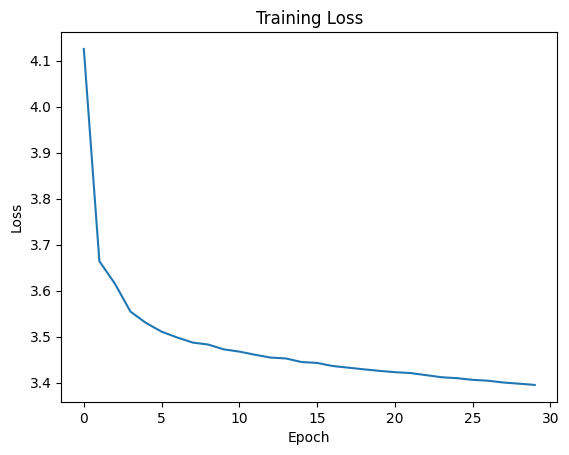

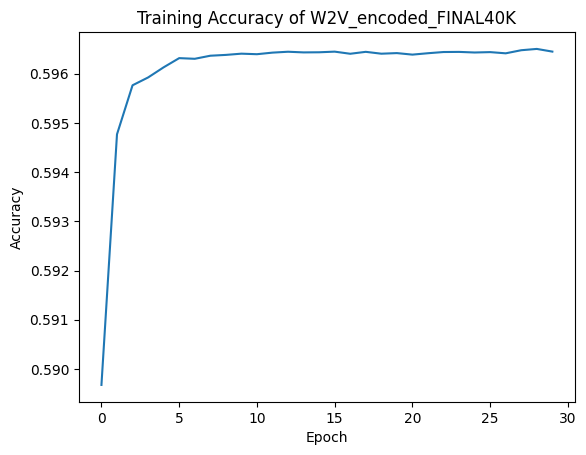

In [58]:
m_name="W2V_encoded_FINAL40K"
save_history(model,history,m_name)
save_model(model,m_name)
plot_training_metrics(history,m_name)


## Testing with Beam Search Decoder

#### Subset data for testing

In [179]:
testing_data= data.sample(5)

#### Check input data formatting

In [92]:
X_train_pad[0]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 11, 13, 14,  8, 15,
       16, 17, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

#### define function to format testing data accordingly

In [ ]:
def prep_test_data(data,Corpus_en):
    data=encode(testing_data["en"],Corpus_en)
    data_pad = pad_sequences(data, maxlen = max_len, padding = "post")
    return data_pad

#### define Beam search decoder

In [194]:

def get_top_n(arr, n):
    """
    Returns the indexes of the n highest values in the array.
    If there are multiple values with the same highest value, all their indexes are returned.
    """
    indexes = np.argpartition(arr, -n)[-n:]
    sorted_indexes = indexes[np.argsort(arr[indexes])][::-1]
    return sorted_indexes


def beam_search_decoder(prediction, beam_size, max_length, conditioning_factor):
    # Initialize beam
    beam = [(list(), 0.0)]  # (sentence, cumulative prob)

    # Iterate over each timestep
    for timestep in range(max_length):
        new_beam = []
        
        for sentence, cumulative_prob in beam:
            #Calculate log probs for next words
            log_probs = np.log(prediction[timestep])
            # Find the top-K words with highest log prob
            top_words = get_top_n(log_probs,beam_size)
            # Create new hypotheses by adding each top word to current sentence
            for word in top_words:
                new_sentence = sentence + [word]
                new_prob = cumulative_prob + log_probs[word] * (conditioning_factor if timestep == 0 else 1.0)  # only for first word
                new_beam.append((new_sentence, new_prob))
        
        # Select top k hypothes with highest cumulative prob
        new_beam.sort(key=lambda x: x[1], reverse=True)
        beam = new_beam[:beam_size]
    
    # Backtrace the best hypothesis to obtain the final predicted sentences as lists of integers
    sentences = []
    for sentence, _ in beam:
        sentences.append(sentence)
    
    return sentences

#### prepare testing data

In [208]:
prep_data= prep_test_data(testing_data["en"][36260],Corpus_en)

Finished encoded data


array([[  763, 16829,  8280,     4,    34, 23354,  1048,    39, 15214,
          488, 40769, 35005,   165,   268,  4081, 40770,    11, 12999,
           14,  2708,    18,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   58,   146,    39,   892,    73,   225,  3093,   320,  8180,
          108,     4,    73,    77,  2017,    55,   735,  3554,    18,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   11,  9334, 16005,  2611,    11, 10674,  7127,   507,    18,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,    

#### get the projected probability distribution from model for a given training set

In [196]:
preds= model.predict(prep_data)
preds
# output of model is given in a probability distribution for every word in a sentence,
# meaning that each sentence output is a 3d array 

array([[[1.6930050e-04, 2.7271234e-03, 4.8138291e-02, ...,
         1.1714236e-08, 1.1706252e-08, 1.1761127e-08],
        [1.6287180e-03, 1.2620933e-03, 6.3987016e-03, ...,
         3.0209113e-09, 3.0418879e-09, 3.0397767e-09],
        [3.2117215e-03, 1.4239626e-03, 1.0473960e-02, ...,
         1.7362985e-09, 1.7652770e-09, 1.7615502e-09],
        ...,
        [9.8379415e-01, 4.6179030e-05, 4.6121550e-05, ...,
         7.7314396e-12, 7.7585169e-12, 7.8248579e-12],
        [9.8567945e-01, 4.0005176e-05, 4.2446536e-05, ...,
         6.0235116e-12, 6.0461527e-12, 6.0894254e-12],
        [9.8622954e-01, 3.8194325e-05, 4.1296258e-05, ...,
         5.5524274e-12, 5.5736275e-12, 5.6111314e-12]],

       [[1.6930050e-04, 2.7271234e-03, 4.8138291e-02, ...,
         1.1714236e-08, 1.1706252e-08, 1.1761127e-08],
        [1.6287178e-03, 1.2620930e-03, 6.3987002e-03, ...,
         3.0209135e-09, 3.0418901e-09, 3.0397789e-09],
        [3.2117211e-03, 1.4239618e-03, 1.0473959e-02, ...,
         1.736

#### Test the beam search decoder on one testing data

In [198]:
predicted_sentences = beam_search_decoder(preds[0], 10, 51, 0.7)
decode(predicted_sentences[2],Corpus_de)

[[11, 36, 11, 11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [11, 36, 11, 11, 11, 16, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [11, 36, 16, 11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [11, 36, 11, 11, 11, 44, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [11, 36, 11, 11, 11, 11, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [11, 36, 16, 11, 11, 16, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [11, 36, 11, 11, 11, 11, 11

['die', 'ist', 'der', 'die', 'die', 'die', 'die']

In [90]:
testing_data["en"]

12688    [also, some, oxidations, can, be, homogeneousl...
Name: en, dtype: object

In [129]:
beam_search_decoder(model,prep_data[0],2,51)

ValueError: Data cardinality is ambiguous:
  x sizes: 51, 3, 51, 51
Make sure all arrays contain the same number of samples.